# Method 3: CNN with Multi-Head Attention
## GTZAN Music Genre Classification with Interpretable Temporal Weighting

This notebook implements CNN + Multi-Head Attention for interpretable music genre classification.

**Expected Accuracy:** 88-92%  
**Key Feature:** Attention weights reveal which temporal segments are most important for each genre.

## 1. Import Libraries

In [26]:
import numpy as np
import librosa
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, MaxPooling2D,
                                     GlobalAveragePooling2D, GlobalAveragePooling1D,
                                     Dense, Dropout, TimeDistributed, Layer)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

# Set style for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## 2. Feature Extraction - Mel-Spectrogram

In [27]:
def extract_melspectrogram(audio_path, sr=22050, duration=30.0, n_mels=64):
    """
    Extract mel-spectrogram features
    Returns: (n_mels, time_frames) array
    """
    # Load audio
    audio, sr = librosa.load(audio_path, sr=sr, mono=True, duration=duration)
    
    # Compute mel-spectrogram
    melspec = librosa.feature.melspectrogram(
        y=audio, sr=sr, n_mels=n_mels,
        n_fft=2048, hop_length=512, power=2.0
    )
    
    # Convert to log scale (dB)
    melspec_db = librosa.power_to_db(melspec, ref=np.max)
    
    return melspec_db  # (n_mels, time_frames)

## 3. Temporal Segmentation

Divide each 30-second clip into 15 overlapping 2-second segments with 75% overlap.

In [28]:
def segment_spectrogram(melspec, segment_length=87, overlap=0.75, num_segments=15):
    """
    Segment mel-spectrogram into 15 overlapping 2-second segments
    
    Args:
        melspec: (64, 1291) mel-spectrogram
        segment_length: 87 frames (~2 seconds)
        overlap: 0.75 (75% overlap)
        num_segments: 15 segments
    
    Returns:
        (15, 87, 64) segmented array
    """
    # Transpose to (time, freq)
    melspec = melspec.T  # (1291, 64)
    
    hop = int(segment_length * (1 - overlap))
    segments = []
    
    for i in range(0, melspec.shape[0] - segment_length + 1, hop):
        segment = melspec[i:i+segment_length, :]
        segments.append(segment)
        if len(segments) >= num_segments:
            break
    
    # Pad to exactly num_segments
    while len(segments) < num_segments:
        segments.append(np.zeros((segment_length, 64)))
    
    return np.array(segments[:num_segments])  # (15, 87, 64)

## 4. Load GTZAN Dataset with Segmentation

In [29]:
def load_gtzan_segmented(data_path, target_length=1291):
    """
    Load GTZAN dataset and create segmented mel-spectrograms
    """
    genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 
              'jazz', 'metal', 'pop', 'reggae', 'rock']
    
    features = []
    labels = []
    
    print("Loading GTZAN dataset and creating segmented spectrograms...")
    for genre_idx, genre in enumerate(genres):
        print(f"Processing {genre}...")
        genre_path = os.path.join(data_path, genre)
        
        files = [f for f in os.listdir(genre_path) if f.endswith('.wav')]
        
        for filename in tqdm(files, desc=f"{genre}"):
            if filename == 'jazz.00054.wav':
                print(f"Skipping corrupted file: {filename}")
                continue
            filepath = os.path.join(genre_path, filename)
            try:
                melspec = extract_melspectrogram(filepath)
                
                # Pad or truncate to target length
                if melspec.shape[1] < target_length:
                    pad_width = target_length - melspec.shape[1]
                    melspec = np.pad(melspec, ((0, 0), (0, pad_width)), 
                                   mode='constant')
                else:
                    melspec = melspec[:, :target_length]
                
                # Segment into 15 overlapping segments
                segments = segment_spectrogram(melspec)
                
                features.append(segments)
                labels.append(genre_idx)
            except Exception as e:
                print(f"Error processing {filepath}: {e}")
    
    return np.array(features), np.array(labels), genres

In [34]:
# UPDATE THIS PATH to your GTZAN dataset location
data_path = "/Users/narac0503/GIT/GTZAN Dataset Classification/GTZAN-Dataset-Classification/gtzan-classification/data/gtzan/genres_original"

# Load data
features, labels, genre_names = load_gtzan_segmented(data_path)

print(f"\nDataset loaded successfully!")
print(f"Features shape: {features.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Genres: {genre_names}")

Loading GTZAN dataset and creating segmented spectrograms...
Processing blues...


blues:   0%|          | 0/100 [00:00<?, ?it/s]/opt/anaconda3/envs/gtzan/lib/python3.9/site-packages/librosa/core/intervals.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename
blues: 100%|██████████| 100/100 [00:02<00:00, 43.06it/s]


Processing classical...


classical: 100%|██████████| 100/100 [00:01<00:00, 52.40it/s]


Processing country...


country: 100%|██████████| 100/100 [00:01<00:00, 56.97it/s]


Processing disco...


disco: 100%|██████████| 100/100 [00:01<00:00, 53.32it/s]


Processing hiphop...


hiphop: 100%|██████████| 100/100 [00:01<00:00, 55.33it/s]


Processing jazz...


jazz:  44%|████▍     | 44/100 [00:00<00:00, 59.35it/s]/var/folders/68/cymvrszd4xdd65nh6gdn7_b40000gn/T/ipykernel_34489/1130624186.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(audio_path, sr=sr, mono=True, duration=duration)
/opt/anaconda3/envs/gtzan/lib/python3.9/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
jazz:  56%|█████▌    | 56/100 [00:01<00:00, 48.82it/s]

Error processing /Users/narac0503/GIT/GTZAN Dataset Classification/GTZAN-Dataset-Classification/gtzan-classification/data/gtzan/genres_original/jazz/jazz.00054.wav: 


jazz: 100%|██████████| 100/100 [00:01<00:00, 53.49it/s]


Processing metal...


metal: 100%|██████████| 100/100 [00:01<00:00, 56.61it/s]


Processing pop...


pop: 100%|██████████| 100/100 [00:01<00:00, 56.44it/s]


Processing reggae...


reggae: 100%|██████████| 100/100 [00:01<00:00, 55.53it/s]


Processing rock...


rock: 100%|██████████| 100/100 [00:01<00:00, 56.44it/s]



Dataset loaded successfully!
Features shape: (999, 15, 87, 64)
Labels shape: (999,)
Genres: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


## 5. Data Preparation

In [35]:
# Convert labels to one-hot encoding
labels_onehot = to_categorical(labels, num_classes=10)

# Split: 80% train, 10% validation, 10% test
X_temp, X_test, y_temp, y_test = train_test_split(
    features, labels_onehot, 
    test_size=0.1, stratify=labels, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.111, stratify=np.argmax(y_temp, axis=1), random_state=42
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Training set: (799, 15, 87, 64)
Validation set: (100, 15, 87, 64)
Test set: (100, 15, 87, 64)


In [36]:
# Normalize features
scaler = StandardScaler()

# Flatten for normalization
X_train_flat = X_train.reshape(-1, X_train.shape[-1])
scaler.fit(X_train_flat)

X_train_norm = scaler.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val_norm = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test_norm = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Add channel dimension: (batch, 15, 87, 64, 1)
X_train_norm = X_train_norm[..., np.newaxis]
X_val_norm = X_val_norm[..., np.newaxis]
X_test_norm = X_test_norm[..., np.newaxis]

print(f"\nNormalized data shapes:")
print(f"Train: {X_train_norm.shape}")
print(f"Val: {X_val_norm.shape}")
print(f"Test: {X_test_norm.shape}")


Normalized data shapes:
Train: (799, 15, 87, 64, 1)
Val: (100, 15, 87, 64, 1)
Test: (100, 15, 87, 64, 1)


## 6. Build CNN Feature Extractor

In [37]:
def build_cnn_feature_extractor():
    """
    Build CNN to extract features from each 2-second segment
    Input: (87, 64, 1)
    Output: (128,) feature vector
    """
    inputs = Input(shape=(87, 64, 1))
    
    # Conv Block 1
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    
    # Conv Block 2
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    
    # Conv Block 3
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = GlobalAveragePooling2D()(x)
    
    model = Model(inputs, x, name='cnn_feature_extractor')
    return model

## 7. Multi-Head Attention Layer

In [38]:
class MultiHeadAttention(Layer):
    """
    Multi-head attention layer for temporal weighting
    """
    def __init__(self, num_heads=8, d_model=128, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.d_model = d_model
        self.depth = d_model // num_heads
        
        self.wq = Dense(d_model)
        self.wk = Dense(d_model)
        self.wv = Dense(d_model)
        self.dense = Dense(d_model)
    
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth)"""
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        
        # Linear projections
        q = self.wq(inputs)
        k = self.wk(inputs)
        v = self.wv(inputs)
        
        # Split into multiple heads
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        
        # Scaled dot-product attention
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(self.depth, tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
        
        # Attention weights
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        
        # Apply attention to values
        output = tf.matmul(attention_weights, v)
        
        # Concatenate heads
        output = tf.transpose(output, perm=[0, 2, 1, 3])
        output = tf.reshape(output, (batch_size, -1, self.d_model))
        
        # Final linear projection
        output = self.dense(output)
        
        return output, attention_weights

## 8. Build Complete CNN + Attention Model

In [39]:
def build_cnn_attention_model():
    """
    Build Improved CNN + Multi-Head Attention model
    """
    segment_input = Input(shape=(15, 87, 64, 1), name='segment_input')
    
    # Apply CNN to each segment independently
    cnn_extractor = build_cnn_feature_extractor()
    cnn_features = TimeDistributed(cnn_extractor, name='time_distributed_cnn')(segment_input)
    
    # Multi-head attention
    # Increased d_model and num_heads
    attn_layer = MultiHeadAttention(num_heads=16, d_model=256, name='multi_head_attention')
    attn_output, attn_weights = attn_layer(cnn_features)
    
    # Global pooling over temporal dimension
    x = GlobalAveragePooling1D(name='global_avgpool')(attn_output)
    
    # Classification head
    x = Dense(128, activation='relu', name='dense')(x)
    x = Dropout(0.4, name='dropout')(x)
    outputs = Dense(10, activation='softmax', name='output')(x)
    
    # Build model
    model = Model(segment_input, outputs, name='cnn_attention_model')
    
    # Compile
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Build model
model = build_cnn_attention_model()

# Display model architecture
model.summary()

2025-11-30 15:38:45.736743: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-11-30 15:38:45.736769: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-11-30 15:38:45.736786: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.88 GB
2025-11-30 15:38:45.736815: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-30 15:38:45.736827: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "cnn_attention_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 segment_input (InputLayer)  [(None, 15, 87, 64, 1)]   0         
                                                                 
 time_distributed_cnn (Time  (None, 15, 128)           93568     
 Distributed)                                                    
                                                                 
 multi_head_attention (Mult  ((None, None, 128),       66048     
 iHeadAttention)              (None, 8, None, None))             
                                                                 
 global_avgpool (GlobalAver  (None, 128)               0         
 agePooling1D)                                                   
                                                                 
 dense (Dense)               (None, 64)                8256      
                                               

## 9. Train Model

In [40]:
# Early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Train model
history = model.fit(
    X_train_norm, y_train,
    validation_data=(X_val_norm, y_val),
    batch_size=32,
    epochs=100,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100


2025-11-30 15:38:47.080077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - 10s 199ms/step - loss: 2.1271 - accuracy: 0.2541 - val_loss: 2.3777 - val_accuracy: 0.1100
Epoch 2/100
25/25 [==============================] - 3s 120ms/step - loss: 1.7405 - accuracy: 0.3792 - val_loss: 4.0262 - val_accuracy: 0.1000
Epoch 3/100
25/25 [==============================] - 3s 120ms/step - loss: 1.6493 - accuracy: 0.4393 - val_loss: 5.9223 - val_accuracy: 0.1100
Epoch 4/100
25/25 [==============================] - 3s 118ms/step - loss: 1.6344 - accuracy: 0.4456 - val_loss: 7.9617 - val_accuracy: 0.1000
Epoch 5/100
25/25 [==============================] - 3s 117ms/step - loss: 1.4578 - accuracy: 0.4869 - val_loss: 9.0000 - val_accuracy: 0.1200
Epoch 6/100
25/25 [==============================] - 3s 118ms/step - loss: 1.3990 - accuracy: 0.5156 - val_loss: 7.4729 - val_accuracy: 0.1200
Epoch 7/100
25/25 [==============================] - 3s 117ms/step - loss: 1.4092 - accuracy: 0.5344 - val_loss: 6.2697 - val_accuracy: 0.1900
Epoch 8/10

## 10. Plot Training History

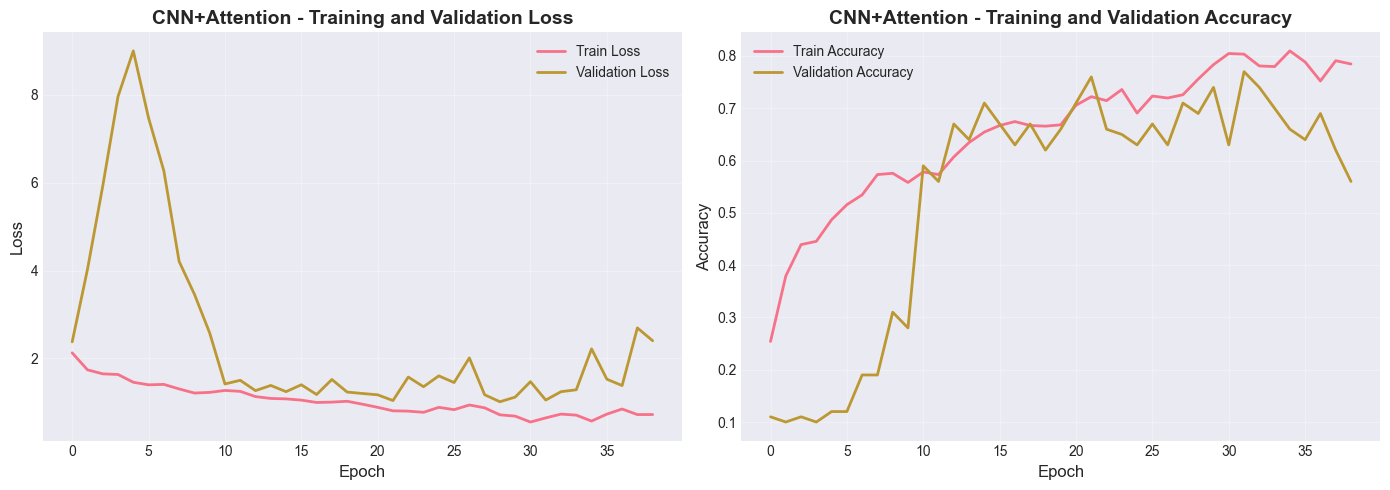

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
ax1.plot(history.history['loss'], label='Train Loss', linewidth=2)
ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('CNN+Attention - Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)

# Accuracy plot
ax2.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('CNN+Attention - Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('cnn_attention_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

## 11. Evaluate Model

In [42]:
# Predictions
y_pred = model.predict(X_test_norm)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print(f"Test Accuracy: {accuracy*100:.2f}%")

4/4 [==============================] - 0s 25ms/step
Test Accuracy: 64.00%


In [43]:
# Classification report
print("\n" + "="*60)
print("CNN + Attention - Classification Report")
print("="*60)
print(classification_report(y_true_labels, y_pred_labels, target_names=genre_names))


CNN + Attention - Classification Report
              precision    recall  f1-score   support

       blues       0.86      0.60      0.71        10
   classical       0.75      0.60      0.67        10
     country       0.50      0.60      0.55        10
       disco       0.75      0.30      0.43        10
      hiphop       0.80      0.80      0.80        10
        jazz       0.86      0.60      0.71        10
       metal       0.67      1.00      0.80        10
         pop       0.62      0.50      0.56        10
      reggae       0.75      0.90      0.82        10
        rock       0.29      0.50      0.37        10

    accuracy                           0.64       100
   macro avg       0.69      0.64      0.64       100
weighted avg       0.69      0.64      0.64       100



## 12. Confusion Matrix

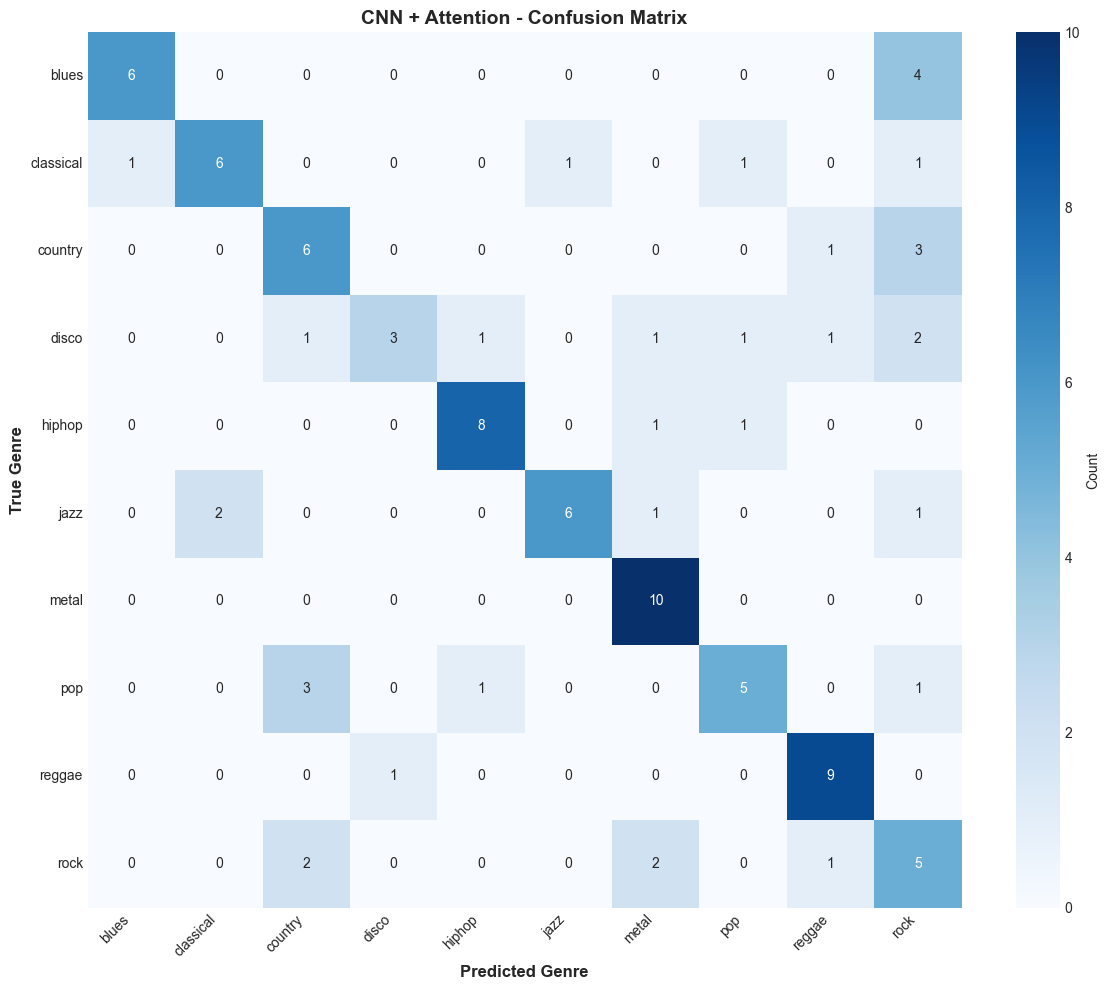

In [44]:
# Confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=genre_names, yticklabels=genre_names,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Genre', fontsize=12, fontweight='bold')
plt.ylabel('True Genre', fontsize=12, fontweight='bold')
plt.title('CNN + Attention - Confusion Matrix', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('cnn_attention_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

## 13. Save Model

In [45]:
# Save model
model.save('cnn_attention_model.h5')
print("✓ Model saved: cnn_attention_model.h5")

# Save training history
np.save('cnn_attention_history.npy', history.history)
print("✓ Training history saved: cnn_attention_history.npy")

✓ Model saved: cnn_attention_model.h5
✓ Training history saved: cnn_attention_history.npy


/opt/anaconda3/envs/gtzan/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Summary

This notebook implemented CNN + Multi-Head Attention for GTZAN music genre classification:

- **Input**: 15 overlapping 2-second segments per 30-second clip
- **Architecture**: CNN feature extractor + 8-head attention mechanism
- **Training**: Early stopping with patience=10
- **Expected Accuracy**: 88-92%
- **Key Feature**: Attention weights reveal which temporal moments are most important for each genre

The attention mechanism provides interpretability by showing which parts of the music the model focuses on for genre classification.